In [ ]:
import pandas as pd

Set working directory to repo root

In [2]:
from utils import get_repo_root
repo_root = get_repo_root()

In [7]:
str(repo_root)

'/Users/batuhansaritas/Desktop/repositories/ing-datathon-team-guney-kampus'

In [ ]:
cust_hist = pd.read_csv(str(repo_root) + '/data/customer_history.csv')
cust = pd.read_csv(str(repo_root) + '/data/customers.csv')
ref_test = pd.read_csv(str(repo_root) + '/data/referance_data_test.csv')
ref = pd.read_csv(str(repo_root) + '/data/referance_data.csv')
sample_sub = pd.read_csv(str(repo_root) + '/data/sample_submission.csv')

In [12]:
cust_hist.head(10)

,cust_id,date,mobile_eft_all_cnt,active_product_category_nbr,mobile_eft_all_amt,cc_transaction_all_amt,cc_transaction_all_cnt
0,0,2016-01-01,1.0,2,151.20,NaN,NaN
1,0,2016-02-01,1.0,2,178.70,NaN,NaN
2,0,2016-03-01,2.0,2,37.38,NaN,NaN
3,0,2016-04-01,4.0,2,100.90,NaN,NaN
4,0,2016-05-01,3.0,3,132.28,NaN,NaN
5,0,2016-06-01,1.0,2,79.86,NaN,NaN
6,0,2016-07-01,1.0,2,121.27,NaN,NaN
7,0,2016-08-01,4.0,2,31.54,NaN,NaN
8,0,2016-09-01,4.0,2,93.80,NaN,NaN
9,0,2016-10-01,5.0,2,52.01,NaN,NaN


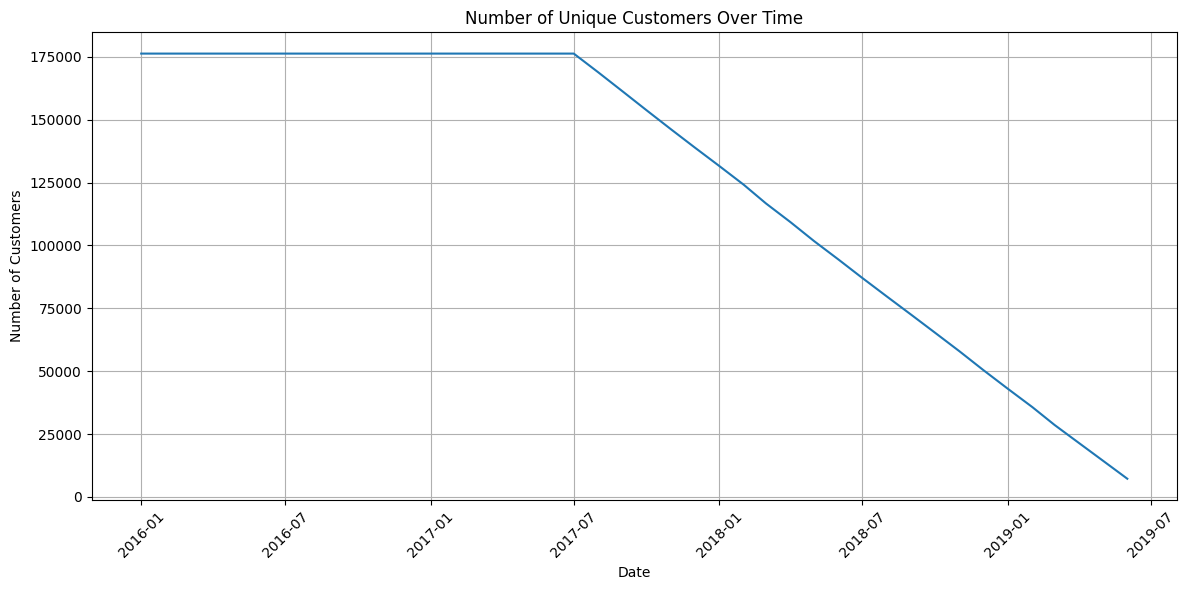

In [ ]:
import matplotlib.pyplot as plt

# Convert date to datetime format
cust_hist['date'] = pd.to_datetime(cust_hist['date'])

# Group by date and count unique customers
customers_per_date = cust_hist.groupby('date')['cust_id'].nunique().reset_index()

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(customers_per_date['date'], customers_per_date['cust_id'])
plt.title('Number of Unique Customers w/ Transaction Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Customers')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [22]:
ref_test.groupby('ref_date').size()

ref_date
2019-01-01    7291
2019-02-01    7074
2019-03-01    7210
2019-04-01    6963
2019-05-01    7211
2019-06-01    7257
dtype: int64